In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

folder_path = '/content/drive/MyDrive/fer2013'

for dirname, _, filenames in os.walk(folder_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/fer2013/fer2013.csv
/content/drive/MyDrive/fer2013/README
/content/drive/MyDrive/fer2013/fer2013.bib


In [ ]:
!pip install scikit-plot
!pip install opencv-python


In [ ]:
!pip install scikit-plot --upgrade
!pip install scipy==1.9.3


In [ ]:
import math
import numpy as np
import pandas as pd

import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fer2013/fer2013.csv')
print(df.shape)
df.head()


(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
df.emotion.value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

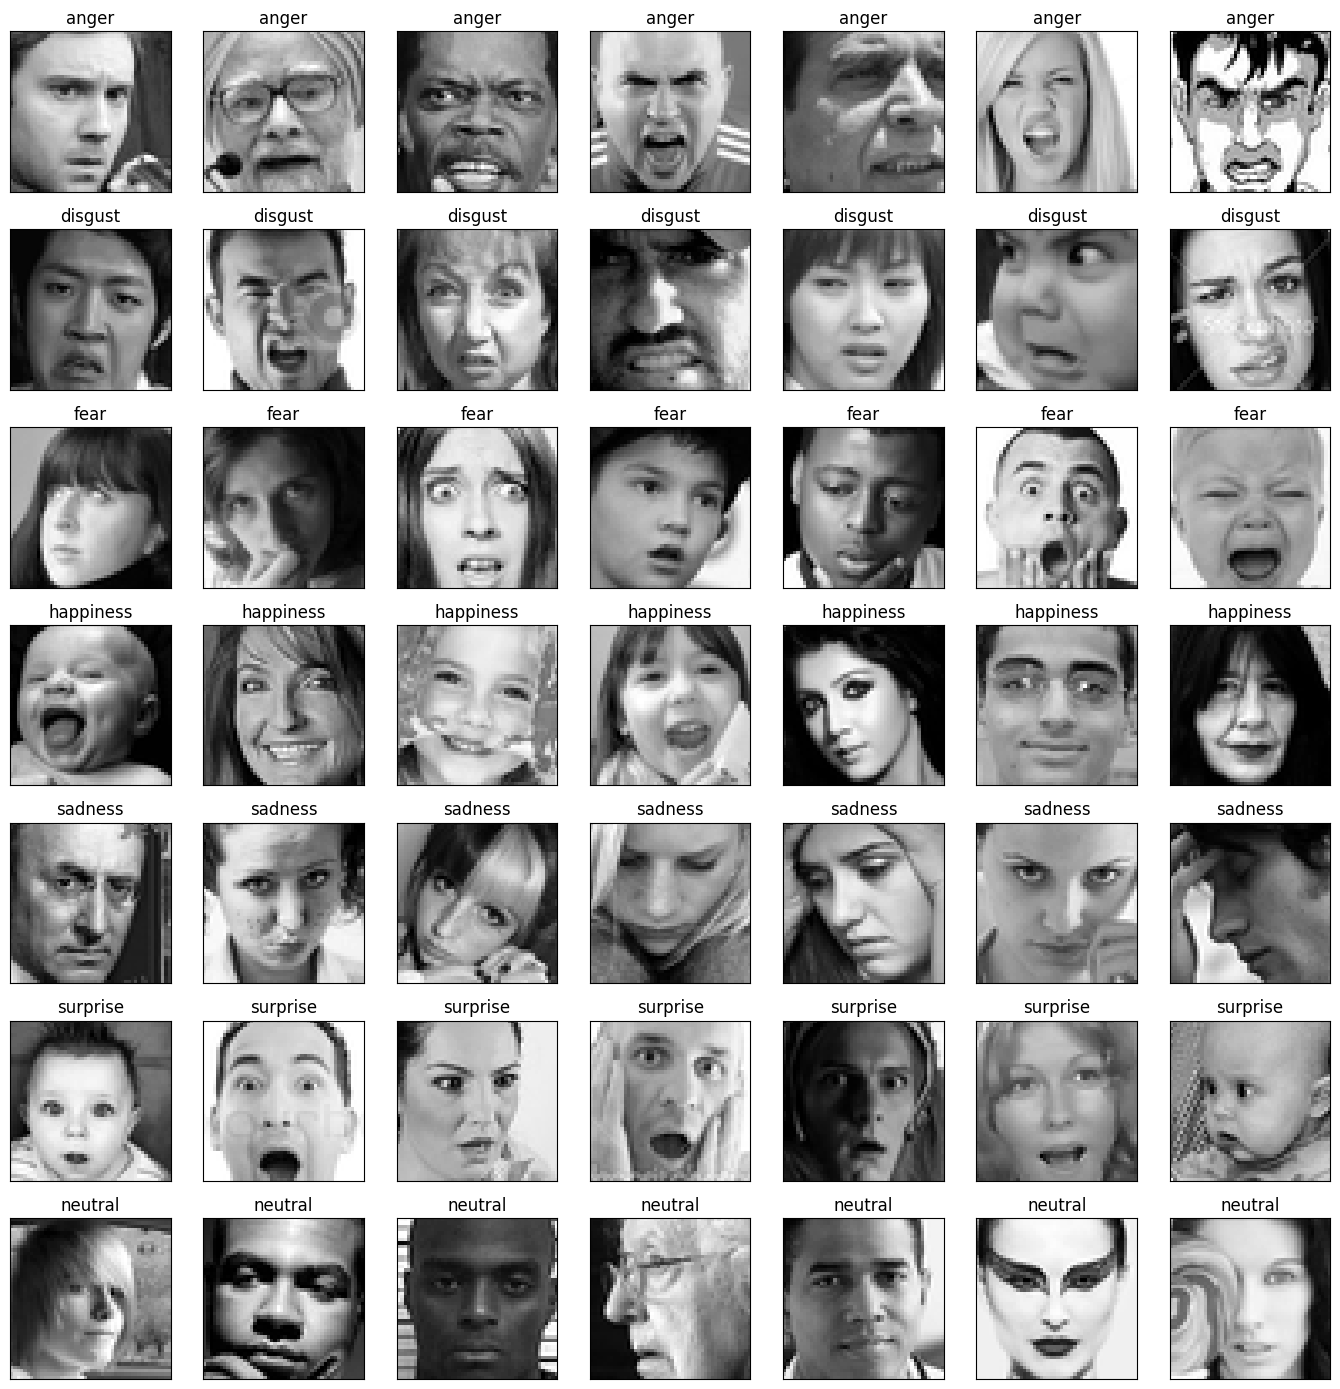

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [ ]:
img_array.shape

(35887, 48, 48)

In [ ]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


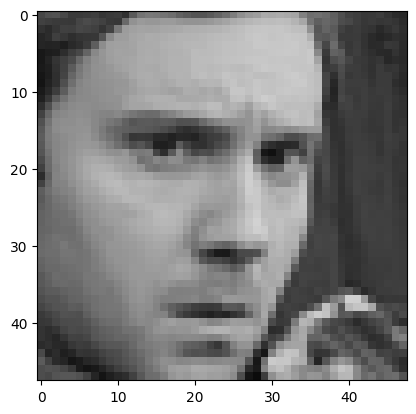

In [ ]:
pyplot.imshow(img_features[0].astype(np.uint8));

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df.emotion)


LabelEncoder()

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# ترميز المشاعر
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)

# تقسيم البيانات
X_train, X_valid, y_train, y_valid = train_test_split(
    img_features,
    img_labels,
    shuffle=True,
    stratify=img_labels,
    test_size=0.1,
    random_state=42
)


In [ ]:
del df
del img_features
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
vgg = tf.keras.applications.VGG16(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.layers import Dropout

def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dropout(0.4)(model)  # تم إضافة Dropout بنسبة 40%
    model = Dense(classes, activation='softmax', name='out_layer')(model)
    return model

In [ ]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 14,718,279 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [checkpoint, lr_scheduler]

In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode='nearest')
train_datagen.fit(X_train)

In [ ]:
# batch size of 32 performs the best.
batch_size = 32
epochs = 120
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [ ]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/120
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8907 - loss: 0.3111
Epoch 1: val_accuracy improved from -inf to 0.68821, saving model to best_model.h5


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 68s 61ms/step - accuracy: 0.8907 - loss: 0.3111 - val_accuracy: 0.6882 - val_loss: 1.1737 - learning_rate: 1.0000e-04
Epoch 2/120
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - accuracy: 0.7812 - loss: 0.4931
Epoch 2: val_accuracy improved from 0.68821 to 0.69016, saving model to best_model.h5


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7812 - loss: 0.4931 - val_accuracy: 0.6902 - val_loss: 1.1630 - learning_rate: 1.0000e-04
Epoch 3/120
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8847 - loss: 0.3269
Epoch 3: val_accuracy did not improve from 0.69016
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - accuracy: 0.8847 - loss: 0.3270 - val_accuracy: 0.6787 - val_loss: 1.1171 - learning_rate: 1.0000e-04
Epoch 4/120
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 46s 47ms/step - accuracy: 0.9062 - loss: 0.1999
Epoch 4: val_accuracy did not improve from 0.69016
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9062 - loss: 0.1999 - val_accuracy: 0.6790 - val_loss: 1.1159 - learning_rate: 1.0000e-04
Epoch 5/120
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8808 - loss: 0.3340
Epoch 5: val_accuracy did not improve from 0.69016
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 80s 58ms/step - accuracy: 0.8808 - loss: 0.3340 - val_accuracy: 0.6785 - val_loss: 1.1750 - learning_r

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 78s 57ms/step - accuracy: 0.8812 - loss: 0.3305 - val_accuracy: 0.6943 - val_loss: 1.1636 - learning_rate: 1.0000e-04
Epoch 8/120
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.8750 - loss: 0.2856
Epoch 8: val_accuracy did not improve from 0.69434
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8750 - loss: 0.2856 - val_accuracy: 0.6904 - val_loss: 1.1727 - learning_rate: 1.0000e-04
Epoch 9/120
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8848 - loss: 0.3162
Epoch 9: val_accuracy did not improve from 0.69434
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.8848 - loss: 0.3162 - val_accuracy: 0.6812 - val_loss: 1.1751 - learning_rate: 1.0000e-04
Epoch 10/120
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - accuracy: 0.9375 - loss: 0.2305
Epoch 10: val_accuracy did not improve from 0.69434
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9375 - loss: 0.2305 - val_accuracy: 0.6826 - val_loss: 1.1804 - learnin

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step - accuracy: 0.9227 - loss: 0.2159 - val_accuracy: 0.6977 - val_loss: 1.3813 - learning_rate: 5.0000e-05
Epoch 16/120
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9375 - loss: 0.2505
Epoch 16: val_accuracy improved from 0.69769 to 0.69797, saving model to best_model.h5


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9375 - loss: 0.2505 - val_accuracy: 0.6980 - val_loss: 1.3838 - learning_rate: 5.0000e-05
Epoch 17/120
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9345 - loss: 0.1836
Epoch 17: val_accuracy improved from 0.69797 to 0.70995, saving model to best_model.h5


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 80s 59ms/step - accuracy: 0.9345 - loss: 0.1836 - val_accuracy: 0.7099 - val_loss: 1.4470 - learning_rate: 5.0000e-05
Epoch 18/120
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - accuracy: 0.9062 - loss: 0.3494
Epoch 18: val_accuracy did not improve from 0.70995
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9062 - loss: 0.3494 - val_accuracy: 0.7086 - val_loss: 1.4477 - learning_rate: 5.0000e-05
Epoch 19/120
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9406 - loss: 0.1709
Epoch 19: val_accuracy did not improve from 0.70995
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - accuracy: 0.9406 - loss: 0.1709 - val_accuracy: 0.6938 - val_loss: 1.3464 - learning_rate: 5.0000e-05
Epoch 20/120
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9688 - loss: 0.1030
Epoch 20: val_accuracy did not improve from 0.70995
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9688 - loss: 0.1030 - val_accuracy: 0.6946 - val_loss: 1.3484 - lea

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9688 - loss: 0.0744 - val_accuracy: 0.7102 - val_loss: 1.8796 - learning_rate: 6.2500e-06
Epoch 43/120
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9782 - loss: 0.0592
Epoch 43: val_accuracy improved from 0.71023 to 0.71245, saving model to best_model.h5


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 78s 58ms/step - accuracy: 0.9782 - loss: 0.0592 - val_accuracy: 0.7125 - val_loss: 1.8607 - learning_rate: 6.2500e-06
Epoch 44/120
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 1.0000 - loss: 0.0114
Epoch 44: val_accuracy improved from 0.71245 to 0.71273, saving model to best_model.h5


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 0.7127 - val_loss: 1.8599 - learning_rate: 6.2500e-06
Epoch 45/120
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9783 - loss: 0.0577
Epoch 45: val_accuracy did not improve from 0.71273
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 58s 57ms/step - accuracy: 0.9783 - loss: 0.0577 - val_accuracy: 0.7094 - val_loss: 1.8821 - learning_rate: 6.2500e-06
Epoch 46/120
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9375 - loss: 0.1015
Epoch 46: val_accuracy did not improve from 0.71273
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9375 - loss: 0.1015 - val_accuracy: 0.7091 - val_loss: 1.8828 - learning_rate: 6.2500e-06
Epoch 47/120
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9791 - loss: 0.0563
Epoch 47: val_accuracy did not improve from 0.71273
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.9791 - loss: 0.0563 - val_accuracy: 0.7072 - val_loss: 1.8908 - lear

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 59s 59ms/step - accuracy: 0.9819 - loss: 0.0445 - val_accuracy: 0.7130 - val_loss: 2.0551 - learning_rate: 1.0000e-07
Epoch 96/120
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.9375 - loss: 0.1202
Epoch 96: val_accuracy did not improve from 0.71301
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9375 - loss: 0.1202 - val_accuracy: 0.7130 - val_loss: 2.0551 - learning_rate: 1.0000e-07
Epoch 97/120
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9824 - loss: 0.0487
Epoch 97: val_accuracy did not improve from 0.71301
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step - accuracy: 0.9824 - loss: 0.0487 - val_accuracy: 0.7122 - val_loss: 2.0545 - learning_rate: 1.0000e-07
Epoch 98/120
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.9688 - loss: 0.0628
Epoch 98: val_accuracy did not improve from 0.71301
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9688 - loss: 0.0628 - val_accuracy: 0.7122 - val_loss: 2.0545 - lea

In [ ]:
val_loss, val_accuracy = model.evaluate(X_valid, y_valid, verbose=0)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")



Validation Accuracy: 71.27%


In [ ]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

model.save('/content/drive/MyDrive/trainedModel/modell.h5')

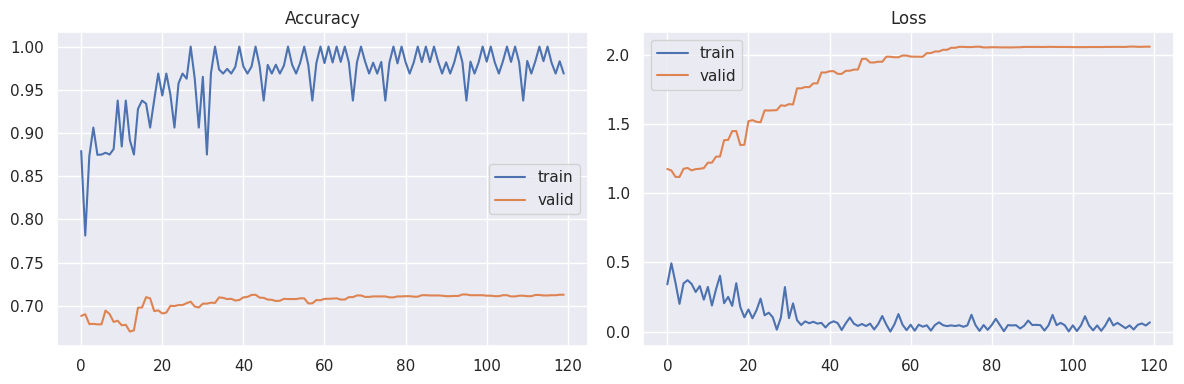

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
total wrong validation predictions: 1031


              precision    recall  f1-score   support

           0       0.63      0.65      0.64       495
           1       0.88      0.65      0.75        55
           2       0.61      0.58      0.59       512
           3       0.89      0.87      0.88       899
           4       0.62      0.57      0.60       608
           5       0.81      0.80      0.80       400
           6       0.64      0.73      0.68       620

    accuracy                           0.71      3589
   macro avg       0.72      0.69      0.71      3589
weighted avg       0.71      0.71      0.71      3589



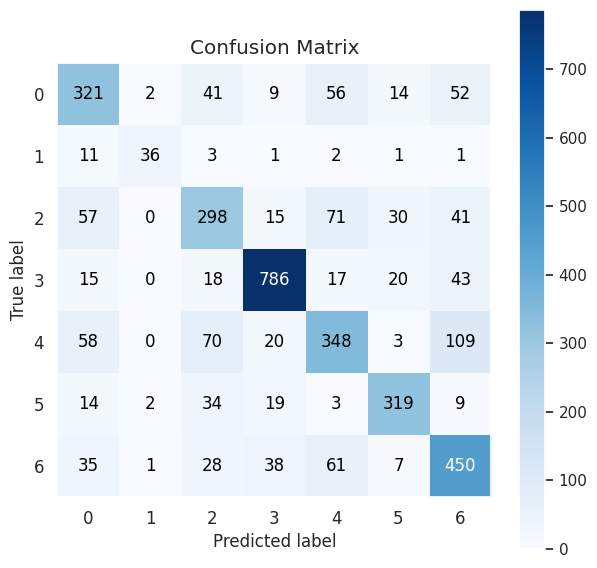

In [ ]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [ ]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


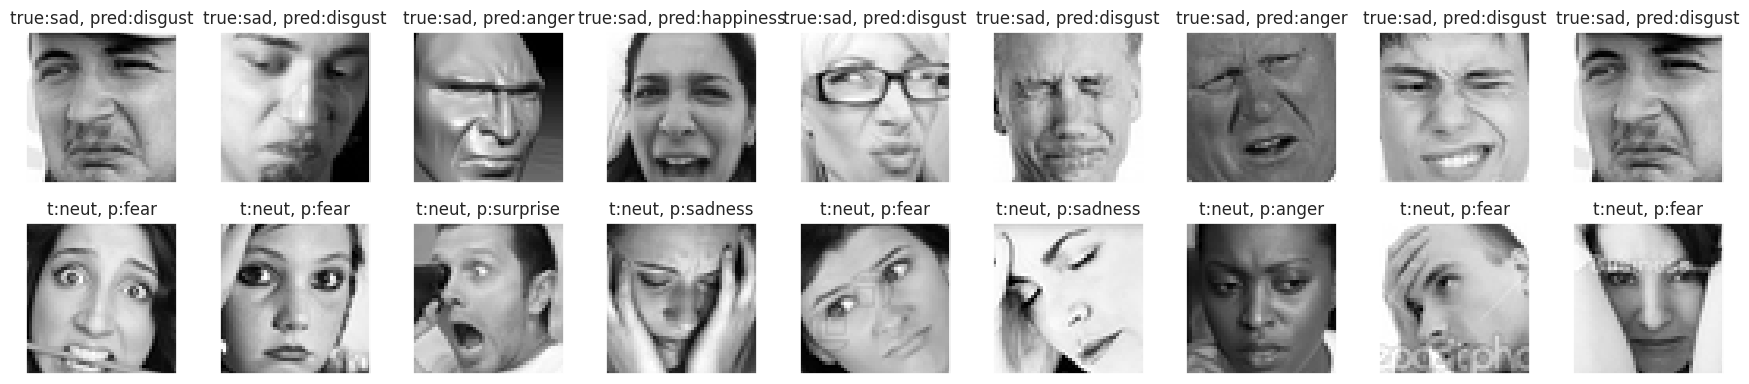

In [ ]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    ax = pyplot.subplot(2, 9, i+1)
    sample_img = X_valid[sadidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)
    ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

    ax = pyplot.subplot(2, 9, i+10)
    sample_img = X_valid[neuidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

    ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

    pyplot.tight_layout()